<a href="https://colab.research.google.com/github/Sharath2021/-LIVE-CLASS-MONITORING-SYSTEM-Face-Emotion-Recognition-/blob/main/LIVE_CLASS_MONITORING_SYSTEM(Face_Emotion_Recognition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries

import os
import cv2
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Colab Notebooks/Capstone Projects/Capstone_Live Class Monitoring System/archive .zip'

In [4]:
# Extracting zip file

with ZipFile(file_name, 'r') as zip:
  zip.extractall(path='fer13')
  print('File extraction done')

File extraction done


In [39]:
#test and train data
test_data = '/content/fer13/test'
train_data = '/content/fer13/train'

In [40]:
#list the directory of test path
os.listdir(test_data)

['sad', 'surprise', 'disgust', 'fear', 'neutral', 'angry', 'happy']

In [41]:
#list the directory of train path
os.listdir(train_data)

['sad', 'surprise', 'disgust', 'fear', 'neutral', 'angry', 'happy']

In [42]:
#define a function to plot some images from different classes

def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray')


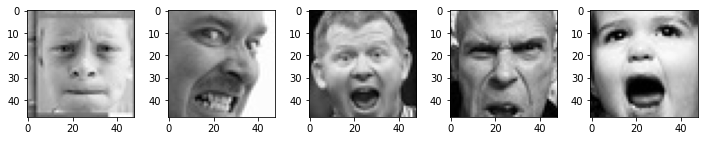

In [44]:
#sample images of angry class
plot_images(train_data+'/angry')

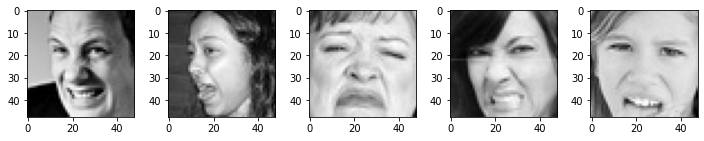

In [45]:
#sample images of disgust class
plot_images(train_data+'/disgust')

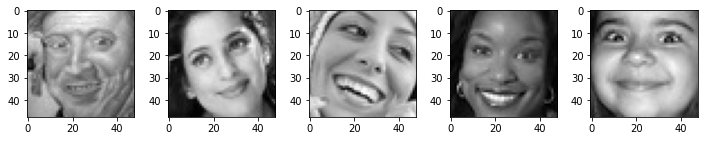

In [46]:
#sample of happy class
plot_images(train_data+'/happy')

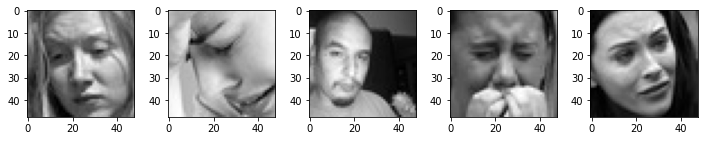

In [47]:
#sample of sad class
plot_images(train_data+'/sad')

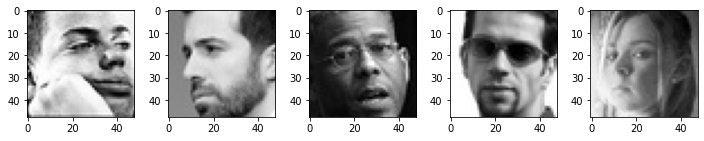

In [48]:
#sample of neutral class
plot_images(train_data+'/neutral')

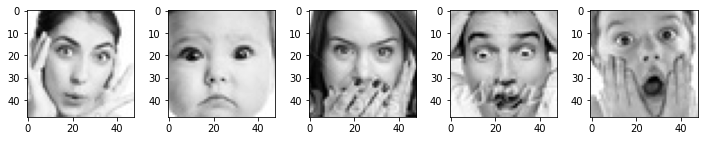

In [49]:
#sample of surprise class
plot_images(train_data+'/surprise')

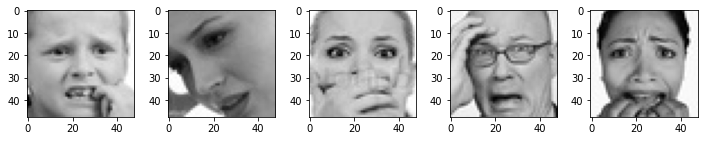

In [51]:
#sample of fear class
plot_images(train_data+'/fear')

In [52]:
# Reading input path

INPUT_PATH = "/content/fer13"

In [6]:
# specifying the image size we want to input in model

picture_size=48

In [7]:
# list of all the classes

classes = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [ ]:
#sample images of angry class
plot_images(train_path+'/angry')

In [9]:
# finding the count of images in each category

category=[]
examples=[]
for i in classes:
    dir=INPUT_PATH + "/"+ 'train/'+i
    onlyfiles = next(os.walk(dir))[2] #dir is your directory path as string
    category.append(i)
    examples.append(len(onlyfiles))

In [10]:
# creating a dataframe for the count of images

example_count_df=pd.DataFrame(category,columns=['Category'],index=[1,2,3,4,5,6,7])
example_count_df['No. of images']=examples
example_count_df

,Category,No. of images
1,angry,3995
2,disgust,436
3,fear,4097
4,happy,7215
5,neutral,4965
6,sad,4830
7,surprise,3171


Text(0.5, 1.0, 'Count of images in each category')

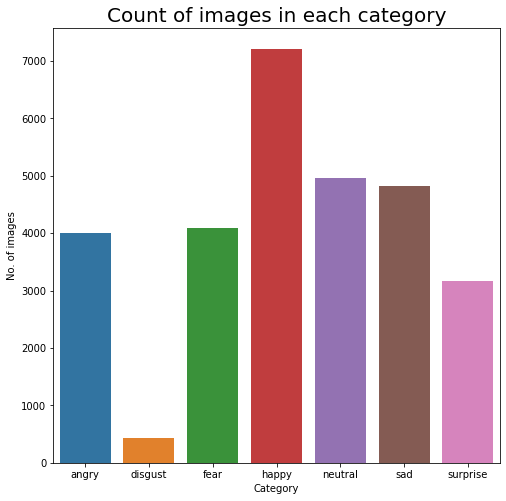

In [11]:
# visualizing

plt.figure(figsize=(8,8))
sns.barplot(x=example_count_df['Category'],y=example_count_df['No. of images'])
plt.title('Count of images in each category',fontsize=20)

In [12]:
# defining the train and test set 
batch_size  = 128

datagen_train  = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(INPUT_PATH + "/"+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(INPUT_PATH + "/"+"test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
# defining a CNN model
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

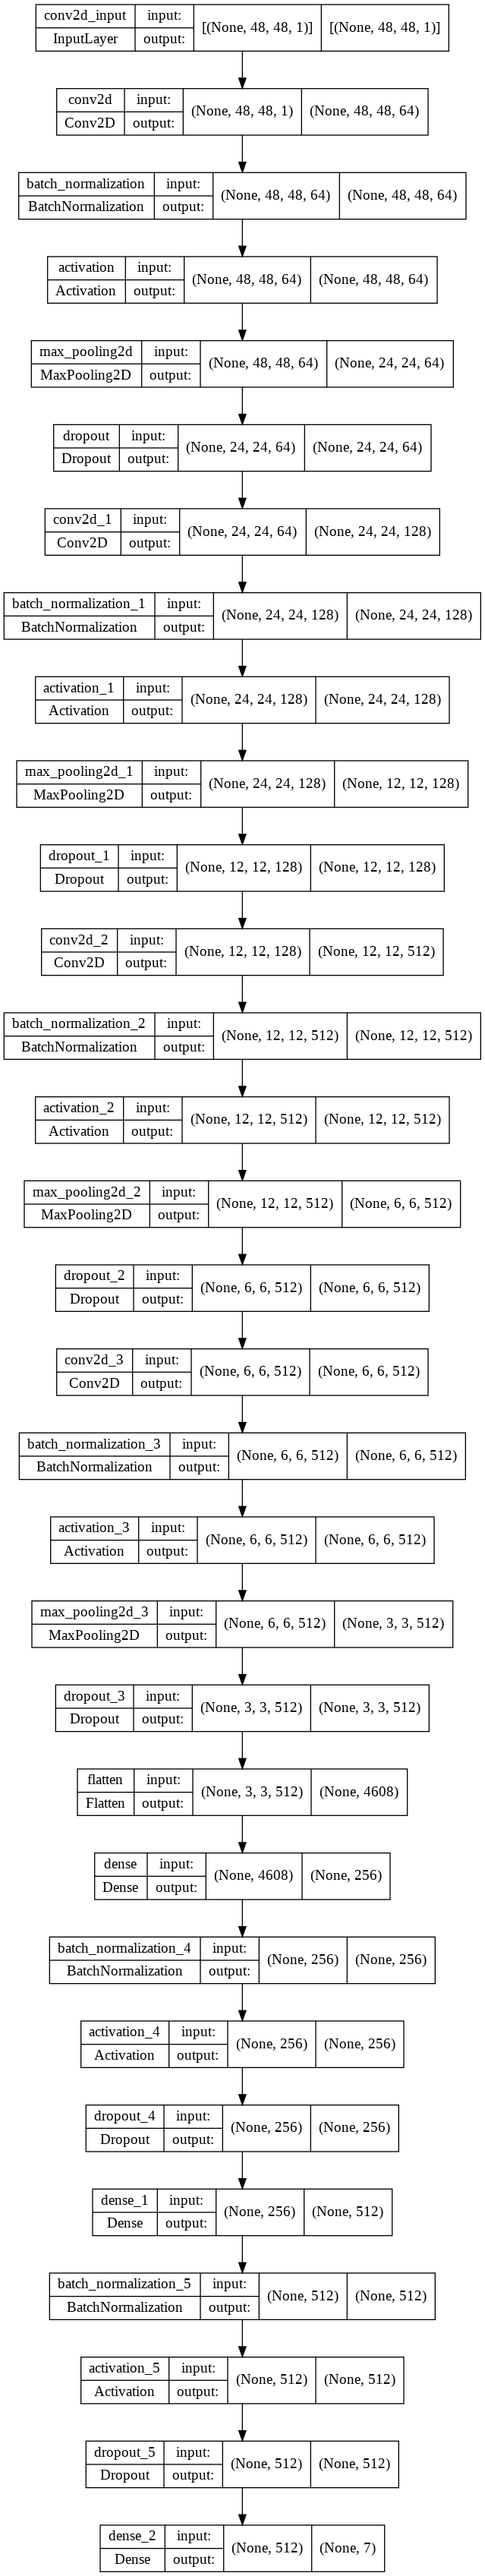

In [14]:
#Visualizing the model

tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=True, expand_nested=True, to_file='model.png')

In [15]:
# defining a callback that will save the best model
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

# defining no. of epoch
epochs = 48

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [16]:
# Fitting and training the model
history = model.fit(train_set,
                        epochs=epochs,
                        validation_data = test_set,
                        callbacks=callbacks_list
                        )

Epoch 1/48
225/225 [==============================] - ETA: 0s - loss: 1.8460 - accuracy: 0.2781
Epoch 1: val_accuracy improved from -inf to 0.24714, saving model to model.h5
225/225 [==============================] - 45s 143ms/step - loss: 1.8460 - accuracy: 0.2781 - val_loss: 1.9628 - val_accuracy: 0.2471
Epoch 2/48
225/225 [==============================] - ETA: 0s - loss: 1.5557 - accuracy: 0.4022
Epoch 2: val_accuracy improved from 0.24714 to 0.35483, saving model to model.h5
225/225 [==============================] - 34s 150ms/step - loss: 1.5557 - accuracy: 0.4022 - val_loss: 1.8295 - val_accuracy: 0.3548
Epoch 3/48
225/225 [==============================] - ETA: 0s - loss: 1.3897 - accuracy: 0.4651
Epoch 3: val_accuracy improved from 0.35483 to 0.43814, saving model to model.h5
225/225 [==============================] - 34s 150ms/step - loss: 1.3897 - accuracy: 0.4651 - val_loss: 1.5289 - val_accuracy: 0.4381
Epoch 4/48
225/225 [==============================] - ETA: 0s - loss: 

In [25]:
model.save('/content/drive/MyDrive/Colab Notebooks/Capstone Projects/Capstone_Live Class Monitoring System/CNN_model.h5')

In [17]:
# Predicting Test Set
predictions=model.predict(test_set)

In [18]:
# loading the saved model
trained_model=load_model('model.h5')


In [19]:
# evaluating the train set
trained_model.evaluate(train_set)

225/225 [==============================] - 23s 102ms/step - loss: 0.5038 - accuracy: 0.8246


[0.5037792921066284, 0.824619472026825]

In [20]:
# evaluating the test set
trained_model.evaluate(test_set)

57/57 [==============================] - 3s 54ms/step - loss: 0.9258 - accuracy: 0.6762


[0.9258118867874146, 0.6762329339981079]

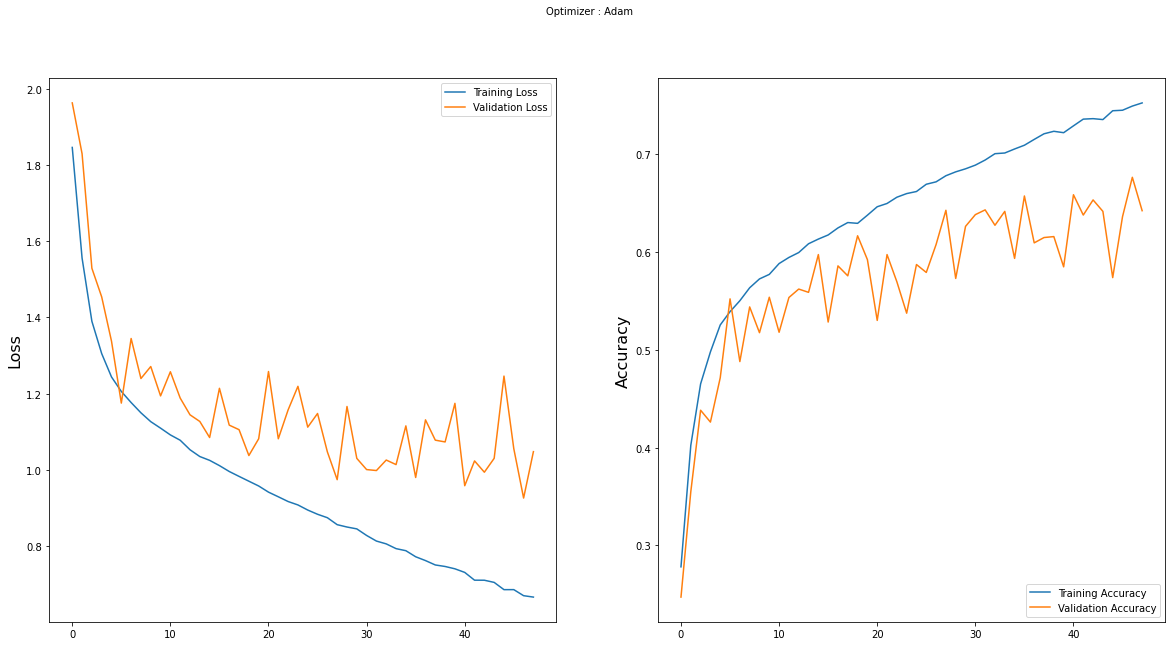

In [21]:
# plotting the Loss for training and validation set
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# plotting the Accuracy for training and validation set
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

<Figure size 432x288 with 0 Axes>

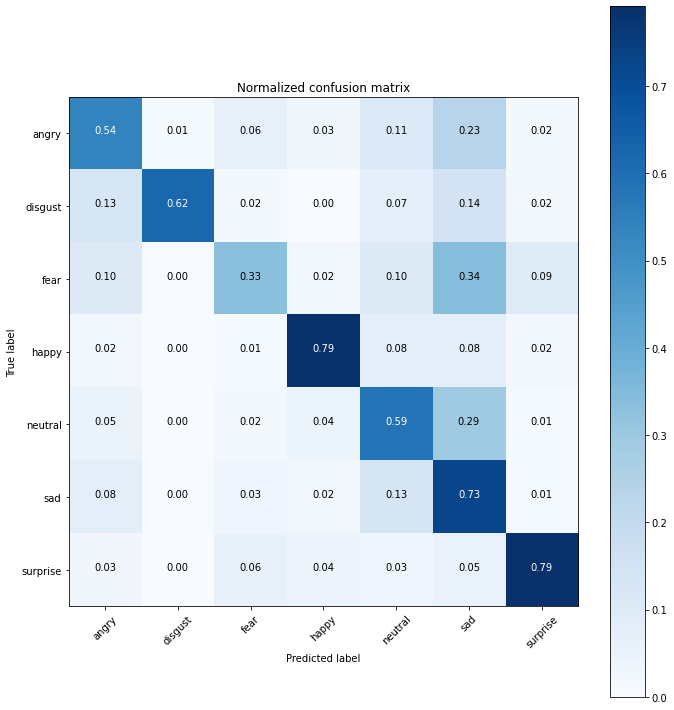

In [28]:
predictions = model.predict_generator(generator=test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()